In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [6]:
def plot_image_histogram_rgb(image, nbins=64):
    # Check if the image is grayscale or RGB
    if len(image.shape) == 2:  # Grayscale image
        # Grayscale histogram
        plt.figure(figsize=(12, 3))
        plt.hist(image.ravel(), bins=nbins, color='gray', edgecolor='black', linewidth=0.5, alpha=0.6, label='Grayscale Histogram')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.title('Grayscale Histogram')
        plt.xlim([0, 255])
        plt.legend()
        plt.tight_layout()
        plt.show()

    elif len(image.shape) == 3 and image.shape[2] == 3:  # RGB image
        # Separate the channels
        red_channel = image[:, :, 0]
        green_channel = image[:, :, 1]
        blue_channel = image[:, :, 2]

        # Plot histograms for each channel
        plt.figure(figsize=(12, 3))

        # Red channel histogram
        plt.hist(red_channel.ravel(), bins=nbins, range=(0, 255), color='red', edgecolor='black', linewidth=0.5, alpha=0.6, label='Red Channel Histogram')

        # Green channel histogram
        plt.hist(green_channel.ravel(), bins=nbins, range=(0, 255), color='green', edgecolor='black', linewidth=0.5, alpha=0.6, label='Green Channel Histogram')

        # Blue channel histogram
        plt.hist(blue_channel.ravel(), bins=nbins, range=(0, 255), color='blue', edgecolor='black', linewidth=0.5, alpha=0.6, label='Blue Channel Histogram')

        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.title('Color Channel Histograms')
        plt.xlim([0, 255])
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Unsupported image format")


In [7]:
def plot_image_histogram_hue(image, nbins=64):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Separate the channels
    hue_channel = hsv_image[:, :, 0]

    # Plot histograms for each channel
    plt.figure(figsize=(12, 3))

    # Hue channel histogram with corresponding color
    hue_hist, bins = np.histogram(hue_channel.ravel(), bins=nbins, range=[0, 180])
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Normalize the bin centers to map them to [0, 1] for colors
    norm_bin_centers = bin_centers / 180

    # Create a color map based on the HSV values
    colors = plt.cm.hsv(norm_bin_centers)

    for i in range(nbins):
        plt.bar(bin_centers[i]*2, hue_hist[i], color=colors[i], width=((bins[1] - bins[0])* 2), edgecolor='black', alpha=0.6)

    plt.title('Hue Channel Histogram with Corresponding Colors')
    plt.xlabel('Hue Value (Degree)')
    plt.ylabel('Frequency')
    plt.xlim([0, 360])

    plt.tight_layout()
    plt.show()

In [8]:
def plot_image_histogram_saturation(image, nbins=64):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Extract the saturation channel
    saturation_channel = hsv_image[:, :, 1]

    plt.figure(figsize=(12, 3))

    # Saturation channel histogram (black to white gradient)
    saturation_hist, bins = np.histogram(saturation_channel.ravel(), bins=nbins, range=[0, 255])
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create a color map from blue to white for value
    colors_saturation = plt.cm.Blues(bin_centers / 255)

    for i in range(nbins):
        plt.bar(bin_centers[i], saturation_hist[i], color=colors_saturation[i], width=(bins[1] - bins[0]), edgecolor='black', alpha=0.6)

    plt.title('Saturation Channel Histogram (Blue to White Gradient)')
    plt.xlabel('Saturation')
    plt.ylabel('Frequency')
    plt.xlim([0, 255])

    plt.tight_layout()
    plt.show()

In [9]:
def plot_image_histogram_value(image, nbins=64):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Extract the value channel
    value_channel = hsv_image[:, :, 2]

    plt.figure(figsize=(12, 3))

    # Value channel histogram (black to white gradient)
    value_hist, bins = np.histogram(value_channel.ravel(), bins=nbins, range=[0, 255])
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create a color map from black to white for value
    colors_value = plt.cm.Greys(bin_centers / 255)

    for i in range(nbins):
        plt.bar(bin_centers[i], value_hist[i], color=colors_value[i], width=(bins[1] - bins[0]), edgecolor='black', alpha=0.6)

    plt.title('Value Channel Histogram (Black to White Gradient)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.xlim([0, 255])

    plt.tight_layout()
    plt.show()

In [10]:
def float2uint8(image_float, is_hsv=False):
    """
    Convert an image from float [0.0, 1.0] to uint8 [0, 255] (for RGB) or [0, 180] (for H channel in HSV)

    Parameters:
    image_float (numpy array): Input image in float format
    is_hsv (Boolean): If the image is in HSV format, scale H channel differently

    Returns:
    numpy array: Image converted to uint8 format
    """
    if is_hsv:
        # H channel is scaled back to its original range of [0, 180]
        h_uint8 = np.clip(image_float[:, :, 0] * 180, 0, 180).astype(np.uint8)
        # S and V channels are scaled back to [0, 255]
        s_uint8 = np.clip(image_float[:, :, 1] * 255, 0, 255).astype(np.uint8)
        v_uint8 = np.clip(image_float[:, :, 2] * 255, 0, 255).astype(np.uint8)
        # Stack the H, S, and V channels back into a single array
        return np.stack((h_uint8, s_uint8, v_uint8), axis=2)
    else:
        # For RGB images, scale all channels uniformly
        return np.clip(image_float * 255, 0, 255).astype(np.uint8)


In [11]:
def uint82float(image_uint8, is_hsv=False):
    """
    Convert an image from uint8 [0, 255] to float [0.0, 1.0]

    Parameters:
    image_uint8 (numpy array): Input image in uint8 format
    is_hsv (Boolean): If the image is in HSV format, scale H differently (0-180 for H, 0-255 for S and V)

    Returns:
    numpy array: Image converted to float format
    """
    if is_hsv:
        # H channel is scaled to [0, 1] from its range of [0, 180]
        h_float = image_uint8[:, :, 0].astype(np.float32) / 180.0
        # S and V channels are scaled to [0, 1] from their range of [0, 255]
        s_float = image_uint8[:, :, 1].astype(np.float32) / 255.0
        v_float = image_uint8[:, :, 2].astype(np.float32) / 255.0
        # Stack the H, S, and V channels back into a single array
        return np.stack((h_float, s_float, v_float), axis=2)
    else:
        # For RGB images, scale all channels uniformly
        return image_uint8.astype(np.float32) / 255.0

def float2uint8(image_float, is_hsv=False):
    """
    Convert an image from float [0.0, 1.0] to uint8 [0, 255] (for RGB) or [0, 180] (for H channel in HSV)

    Parameters:
    image_float (numpy array): Input image in float format
    is_hsv (Boolean): If the image is in HSV format, scale H channel differently

    Returns:
    numpy array: Image converted to uint8 format
    """
    if is_hsv:
        # H channel is scaled back to its original range of [0, 180]
        h_uint8 = np.clip(image_float[:, :, 0] * 180, 0, 180).astype(np.uint8)
        # S and V channels are scaled back to [0, 255]
        s_uint8 = np.clip(image_float[:, :, 1] * 255, 0, 255).astype(np.uint8)
        v_uint8 = np.clip(image_float[:, :, 2] * 255, 0, 255).astype(np.uint8)
        # Stack the H, S, and V channels back into a single array
        return np.stack((h_uint8, s_uint8, v_uint8), axis=2)
    else:
        # For RGB images, scale all channels uniformly
        return np.clip(image_float * 255, 0, 255).astype(np.uint8)

In [2]:
# Load images from URLs
!wget https://raw.githubusercontent.com/yyhtbs-yye/data4wget/main/images/image_proc_lenna.png
!wget https://raw.githubusercontent.com/yyhtbs-yye/data4wget/main/images/image_proc_boats.png

--2024-10-08 15:51:12--  https://raw.githubusercontent.com/yyhtbs-yye/data4wget/main/images/image_proc_lenna.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘image_proc_lenna.png’

image_proc_lenna.pn 100%[===================>] 462.73K  --.-KB/s    in 0.07s   

2024-10-08 15:51:12 (6.59 MB/s) - ‘image_proc_lenna.png’ saved [473831/473831]

--2024-10-08 15:51:12--  https://raw.githubusercontent.com/yyhtbs-yye/data4wget/main/images/image_proc_boats.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [3]:
# Convert images to numpy arrays
lenna_image = Image.open("image_proc_lenna.png")
boats_image = Image.open("image_proc_boats.png")

lenna_image = np.array(lenna_image)
boats_image = np.array(boats_image)

In [4]:
# Generate sinusoidal mask for Lenna image
ff = 10

H, W, _ = lenna_image.shape
x = np.linspace(0, ff * 2 * np.pi, W)
y = np.ones((H))
X, Y = np.meshgrid(x, y)
sin_mask = (np.sin(X) * Y)

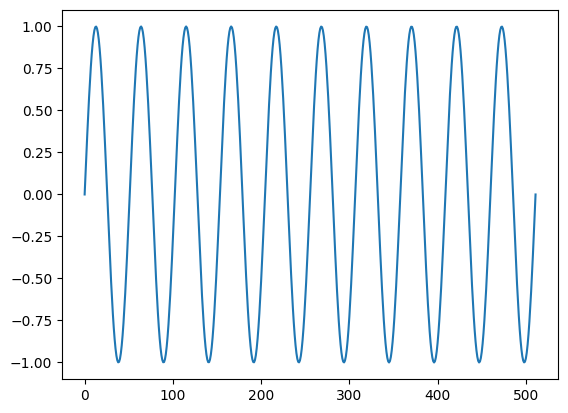

In [16]:
sin_x=np.sin(x)
plt.plot(sin_x)

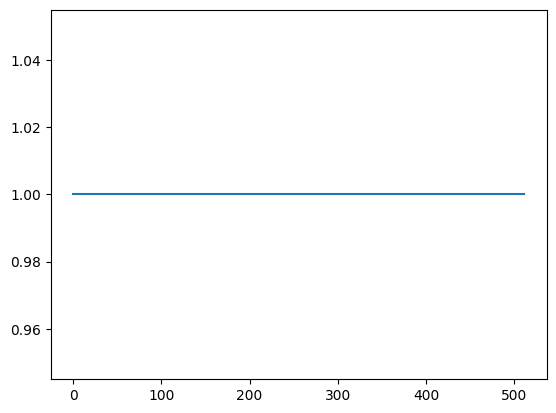

In [17]:
plt.plot(y)

In [12]:
lenna_image_float = uint82float(lenna_image)
boats_image_float = uint82float(boats_image)

In [18]:
# Normalize the mask between 0 and 1
sin_mask_normalized = (sin_mask - sin_mask.min()) / (sin_mask.max() - sin_mask.min())

# Generate complementary mask (1 - sin_mask) for the Boat image
complementary_mask = 1 - sin_mask_normalized

# Convert the masks to 3 channels (RGB)
sin_mask_rgb = np.stack([sin_mask_normalized] * 3, 2)
complementary_mask_rgb = np.stack([complementary_mask] * 3, 2)

In [19]:
# Apply masks to the images (element-wise multiplication)
lenna_masked = lenna_image_float * sin_mask_rgb
boats_masked = boats_image_float * complementary_mask_rgb

# Add the two masked images together
blended_image_float = lenna_masked + boats_masked

# Convert the result back to uint8 format
blended_image = float2uint8(blended_image_float)

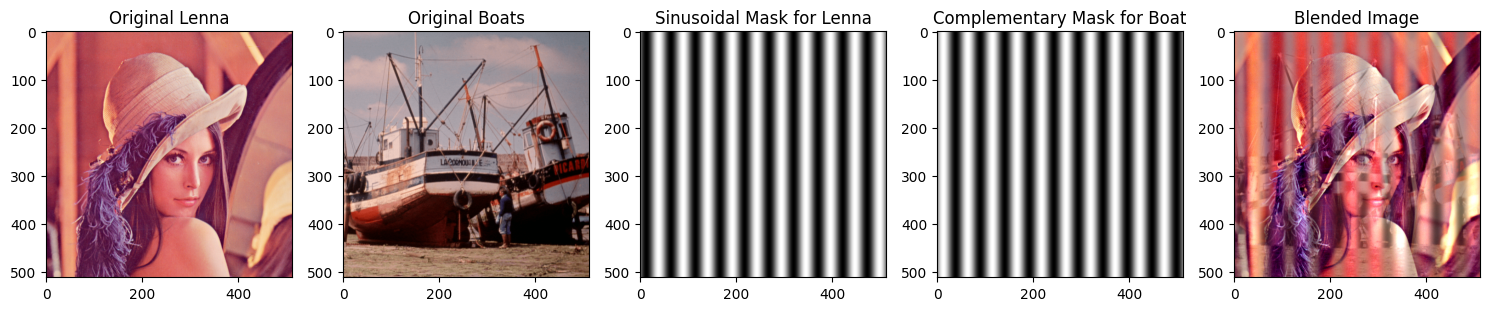

In [23]:
# Plot the original images, masks, and the blended image
plt.figure(figsize=(15, 3))

# Original Lenna image
plt.subplot(1, 5, 1)
plt.title("Original Lenna")
plt.imshow(lenna_image)

# Original Boat image
plt.subplot(1, 5, 2)
plt.title("Original Boats")
plt.imshow(boats_image)

# Sinusoidal mask for Lenna
plt.subplot(1, 5, 3)
plt.title("Sinusoidal Mask for Lenna")
plt.imshow(sin_mask_normalized, cmap='gray')

# Complementary mask for Boat
plt.subplot(1, 5, 4)
plt.title("Complementary Mask for Boat")
plt.imshow(complementary_mask, cmap='gray')

# Blended image
plt.subplot(1, 5, 5)
plt.title("Blended Image")
plt.imshow(blended_image)

plt.tight_layout()
plt.show()

In [22]:
# Generate sinusoidal mask for Lenna image
ff = 10

H, W, _ = lenna_image.shape
x = np.linspace(0, ff * 2 * np.pi, W)
y = np.ones((H))
X, Y = np.meshgrid(x, y)
sin_mask = (np.sin(X) * Y)

sin_x=np.sin(x)
sin_y=np.sin(y)

X, Y = np.meshgrid(sin_x, sin_y)